In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import pandas as pd
import numpy as np
import codecs
import argparse
import math
from scipy.special import comb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import scipy.integrate as integrate
from scipy.integrate import quad
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import floor, log10

parser = argparse.ArgumentParser(description='Plotting data.')
parser.add_argument('--dataset', type=str, help='dataset', default='vool_stats.csv')
parser.add_argument('--inpath', type=str, help='where the dataset is lcoated', default='../../../resources/')
parser.add_argument('--outpath', type=str, help='where to put the charts', default='../../../output/')
args, unknown = parser.parse_known_args()

# ==============================================================================
# Chart variables
# ==============================================================================
titlesize = 16
subtitlesize = 14
labelsize = 14
axessize = 12
legendsize = 11
markersize = 5

# http://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
plt.rcParams.update(plt.rcParamsDefault)
# plt.style.use('grayscale')
# plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
font = font_manager.FontProperties(family='serif', size=legendsize)

# Markers - https://matplotlib.org/api/markers_api.html
markers = ["v", "^", "<", ">", "8", "s", "p", "P", "*", "+", "X", "D", "o", "s"]
linestyle_tuple = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or ':'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot')]  # Same as '-.'

linestyle_tuple2 = [
#      ('loosely dotted',        (0, (1, 10))),
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),

#      ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),

#      ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),

     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
#      ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]
greyscale = ['silver', 'grey', 'lightgrey', 'black']

# Lines - https://matplotlib.org/gallery/lines_bars_and_markers/line_styles_reference.html

# =============================================================================
# Location String	Location Code
# 'best'	0
# 'upper right'	1
# 'upper left'	2
# 'lower left'	3
# 'lower right'	4
# 'right'	5
# 'center left'	6
# 'center right'	7
# 'lower center'	8
# 'upper center'	9
# 'center'	10
# =============================================================================

# =============================================================================
# These are the "Tableau 20" colors as RGB.
# http://www.randalolson.com/2014/06/28/how-to-make-beautiful-data-visualizations-in-python-with-matplotlib/
# =============================================================================
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

# ==============================================================================
path = args.inpath
outpath = args.outpath
filename = args.dataset

# datasets = ["Foodmart", "SSB"]  # ["dataset_patrick", "dataset_patrick_ssb"]
# data = pd.DataFrame()
# with codecs.open(path + filename, 'r', encoding='utf-8') as f:
#     data = pd.read_csv(f, sep=';')
#     # data.infer_objects()
# data["dataset"] = data["dataset"].apply(lambda x: "SSB" if "ssb" in x else "Foodmart")
# data["synMeta"] = data["synMeta"] + 1
# msize, m, ls, l, c = marker(filename)

# You typically want your plot to be ~1.33x wider than tall. This plot is a rare
# exception because of the number of lines being plotted on it.
# Common sizes: (10, 7.5) and (12, 9)
# Make room for the ridiculously large title.
# plt.subplots_adjust(top=0.8)
figsize11 = (4, 3)
figsize12 = (8, 3)
figsize13 = (12, 3)
figsize22 = (8, 6)
col_width = 0.15

def default_plotsetup(ax):
    ax.grid(color="lightgray", linestyle='-', linewidth=0.3)
    ax.set_axisbelow(True)

In [2]:
df = pd.read_csv(path + filename)

df.describe()
min_python_time = df[(df["module"].isin(["Correlation", "SlicingVariance", "DomainVariance", "AggregationVariance"])) & (df["card"] == 100)]["time"].min() + 1
df["module"].unique()
df["time"] = df.apply(lambda x: x["time"] - (min_python_time if x["module"] not in ["Top-K", "Bottom-K", "Statistics", "Preamble", "Mckp", "mkcp", "Assess"] else 0), axis=1)
df["time"] = df["time"] + 1
df["time"] = df["time"] / 1000

def round_power_of_10(n):
    import math
    exp = math.log(n, 10)
    exp = round(exp)
    return 10 ** exp

d = {
    "assess": "Assess",
    "skyline": "Skyline",
    "clustering": "Clustering",
    "cardvariance": "CardVariance",
    "sadincrease": "SliceVariance",
    "outlierdetection": "OutlierDetection",
    "preamble": "Preamble",
    "correlation": "Correlation",
    "intravariance": "AggregationVariance"
}
df["module"] = df["module"].replace(d)
df["time"] = df["time"].apply(lambda x: x) #round_power_of_10(x)
# df = df[df["seed"] == df["seed"].max()]
df = df[df["card"] == df["limit"]]
df = df[df["module"] != "Mckp"]
df = df[df["module"] != "UniformAggregationVariance"]
df[df["time"] < 0]

,card,cube,length,limit,module,npatterns,seed,sessionid,time,uid


In [3]:
def init_X(left):
    def v(X):
        X = X.sort_values(["time"])
        X["c"] = 1
        # X["cum_time"] = X["time"].cumsum().apply(lambda x: x)
        X["cum_c"] = X["c"].cumsum()
        X["cum_c"] = X.apply(lambda x: x ["cum_c"] / X["cum_c"].max(), axis=1)
        return X
    if not left:
        X = df
    else:
        X = df[(df["uid"] == 118) | (df["uid"] == 132) | (df["uid"] == 150)]
    X = X[X["module"] != "mkcp"].groupby(["uid", "card"]).apply(lambda x: v(x)).reset_index(drop=True)[["uid", "card", "time", "cum_c", "module", "length"]]
    X["id"] = X.apply(lambda x: str(x["uid"]) + "-" + str(x["card"]), axis=1)
    return X

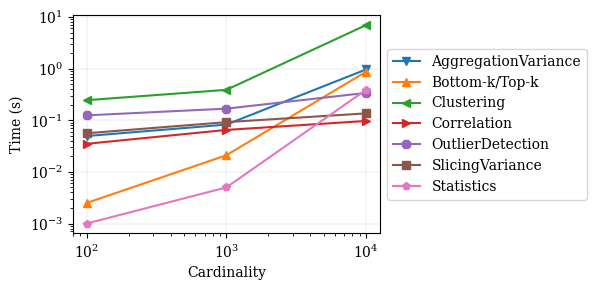

In [4]:
fig, axs = plt.subplots(1, 1, figsize=figsize11)

# X = init_X(True)
# for key, group in X.groupby(["id"]):
#     axs[0].plot(group["time"], group["cum_c"], label=key)
#     default_plotsetup(axs[0])
#     axs[0].set_xscale("log")
#     # axs[0].set_xlim([0.1, 10])
#     # axs[0].set_xticks([0.1, 1, 10])
#     axs[0].legend()

i = 0
X = init_X(False)
X["time"] = X.apply(lambda x: x["time"], axis=1)
X = X[X["module"] != "Preamble"]
X = X[X["module"] != "Bottom-K"]
X["module"] = X["module"].replace("Top-K", "Bottom-k/Top-k")
X = X[X["module"] != "Skyline"]
X = X[X["module"] != "Assess"]
X = X[X["module"] != "DomainVariance"]
# X["time"] = X.apply(lambda x: (x["time"] + 0.01) if x["module"] == "Correlation" and x["card"] == 1000 else x["time"], axis=1)
# X["time"] = X.apply(lambda x: (x["time"] + 0.1) if x["module"] == "Skyline" and x["card"] == 10000 else x["time"], axis=1)

msize = 10
for key, group in X.groupby(["module"]):
    ax = axs # axs[0]
    x = group.groupby(["card"])
    x = [x for x in x.groups.keys()]
    y = group.groupby(["card"])["time"].median()
    y = y.tolist()
    ax.plot(x, y, label=key, marker=markers[i]) # , markersize=msize, linestyle=linestyle_tuple[i % len(linestyle_tuple)][1]
    msize -= 0.5
    i += 1
    default_plotsetup(ax)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_yticks([0.001, 0.01, 0.1, 1, 10])
    ax.set_xticks([100, 1000, 10000])
    ax.set_xlabel("Cardinality")
    ax.set_ylabel("Time (s)")
fig.tight_layout()
fig.savefig(outpath + "scalability.svg", bbox_inches = 'tight')
fig.savefig(outpath + "scalability.pdf", bbox_inches = 'tight')
fig

14.5


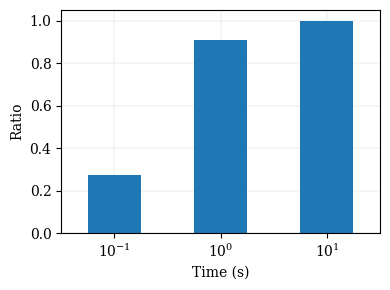

In [5]:
# ax = axs[1]
fig, axs = plt.subplots(1, 1, figsize=figsize11)
ax = axs

X = init_X(False)
X = X[X["card"] == 10000]

print(X[X["module"] == "Preamble"]["length"].mean())

X = X[X["module"] != "Preamble"]
X = X.groupby(["module"]).mean().reset_index()
X["time"] = X["time"].apply(lambda x: round_power_of_10(x))
# X["time"] = X["time"].apply(lambda x: x)
X = X.groupby(["time"])["module"].count().cumsum()
X = X / X.max()
X.plot(kind="bar",ax=ax) #  
ax.set_xticklabels(["$10^{-1}$", "$10^{0}$", "$10^{1}$"], rotation=0)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Ratio")
default_plotsetup(ax)
fig.tight_layout()
fig.savefig(outpath + "ratio.svg")
fig.savefig(outpath + "ratio.pdf")
fig

In [6]:
df = pd.read_csv(path + "formResponses.csv")
df

,Timestamp,Email Address,Hai seguito il corso di Business Intelligence?,"Hai già avuto esperienza con tool di BI? (E.g., Tableau)",Hai familiarità con la lingua inglese?,D1.1 Quali sono gli aspetti che ritieni salienti del risultato della query?,Quanto bene il testo prodotto da VOOL descrive il risultato della query?,Quanto è interessante la descrizione proposta dal singolo pattern? [Grouped by PRODUCT_DEPARTMENT the average QUANTITY is 13399.],"Quanto è interessante la descrizione proposta dal singolo pattern? [Facts can be grouped into 3 clusters, the largest has 11 facts and 3606 as average QUANTITY, the second has 6 facts and 16375 as average QUANTITY, the third has 5 facts and 31372 as average QUANTITY.]",Quanto è interessante la descrizione proposta dal singolo pattern? [The fact with anomalous QUANTITY is (Produce) with QUANTITY 37787.],...,D2.3 Quanto---la descrizione di VOOL---ha messo in risalto aspetti che ritieni salienti del risultato?,D3.1 Quali sono gli aspetti che ritieni salienti del risultato della query?.1,Quanto bene il testo prodotto da VOOL descrive il risultato della query?.5,"Quanto è interessante la descrizione proposta dal singolo pattern? [Grouped by PRODUCT_CATEGORY the average REVENUE is 13183, the average COST is 5636.]",Quanto è interessante la descrizione proposta dal singolo pattern? [COST and REVENUE show strong correlation.],"Quanto è interessante la descrizione proposta dal singolo pattern? [The facts whose REVENUE and COST are both higher than those of all other facts are (Vegetables), (Snack Foods), and (Beer and Wine).]","Quanto è interessante la descrizione proposta dal singolo pattern? [Facts can be grouped into 2 clusters, the largest has 41 facts and 9138 as average REVENUE, 3647 as average COST, the second has 4 facts and 54647 as average REVENUE, 26021 as average COST.]",D3.3 Quanto---la descrizione di VOOL---ha messo in risalto aspetti che ritieni salienti del risultato?.1,"Fornisci indicazione aggiuntive circa esperienza di VOOL. (e.g., cosa ti è piaciuto? cosa miglioreresti?)",Come valuti la user experience con VOOL?
0,2/18/2022 9:04:26,matteo.golfarelli@unibo.it,Sì,Sì,5,"Molta differenza tra i valori, probabilmente r...",4,5,4,5,...,5,I due valori sono linearmente correlati,5,4,5,NaN,3,5,In alcuni casi evidenzia aspetti che sono diff...,4
1,2/22/2022 9:47:14,stefano.rizzi@unibo.it,Sì,No,5,There is a high variance in the quantities sol...,4,3,3,5,...,3,"There is a linear relationship, except for B&W...",3,4,5,NaN,1,3,Risposte molto ripetitive. A volte l'ordine de...,4
2,2/22/2022 14:58:00,enrico.gallinucci@unibo.it,Sì,Sì,5,Ci sono 3 (o 5) prodotti che hanno venduto mol...,4,4,5,4,...,4,"C'è una forte correlazione e un unico, forte o...",4,4,5,5.0,3,4,La descrizione di alcuni pattern dovrebbe esse...,5
3,2/22/2022 17:34:57,josephgiovanelli@gmail.com,Sì,Sì,4,"Esistono reparti che vendono moltissimo, altri...",4,2,5,3,...,4,andamento lineare tranne outlier (quali in fav...,4,2,5,5.0,3,4,"Bello che clusterizza, che fa vedere gli outli...",5
4,3/25/2022 13:37:09,andrea.negri4@studio.unibo.it,Sì,Sì,4,Vedere quali sono i prodotti più venduti (prod...,5,3,5,5,...,5,Esistono categorie molto redditizie ma anche m...,4,3,4,4.0,3,3,.,5
5,3/25/2022 13:55:40,vladmattiussi@gmail.com,Sì,Sì,5,"Alcoholic, Produce e Snack Foods sono le categ...",1,4,1,5,...,4,"Latticini, carne e frutta rendono elevati guad...",2,1,4,5.0,1,1,Vool è molto preciso ma non fornisce sempre le...,3
6,3/30/2022 11:10:46,asia.lucchi@studio.unibo.it,Sì,Sì,4,Il dipartimento più comune è quello chiamato g...,4,2,4,5,...,4,Buona parte delle categorie segue un andamento...,4,2,5,5.0,2,4,Le deduzioni sulle anomalie mi sono sembrate l...,4
7,3/30/2022 12:34:31,luca.rossi57@studio.unibo.it,Sì,Sì,5,Il prodotto più venduto è Produce con più di 3...,5,4,4,4,...,5,capire quali categorie fanno guadagnare di più...,4,3,4,5.0,2,3,a volte la descrizione di vool dice cose che s...,4
8,3/31/2022 13:16:59,matteo.castellucci3@studio.unibo.it,N

Quanto bene il testo prodotto da VOOL descrive il risultato della query?

In [7]:
df[[x for x in df.columns if "Quanto bene il testo prodotto da VOOL descrive il risultato della query?" in x]].agg([np.mean, np.std], axis=0).agg([np.mean], axis=1)

,mean
mean,3.800000
std,0.913765


Interesse medio dei singoli insights (Quanto è interessante la descrizione proposta dal singolo pattern?)

In [8]:
df[[x for x in df.columns if "Quanto è interessante la descrizione proposta dal singolo pattern?" in x]].agg([np.mean, np.std], axis=0).agg([np.mean], axis=1)

,mean
mean,3.527174
std,0.920349


User experience

In [9]:
df[[x for x in df.columns if "Come valuti la user experience con VOOL?" in x]].agg([np.mean, np.std], axis=0).agg([np.mean], axis=1)

,mean
mean,4.200000
std,0.632456


Quanto---la descrizione di VOOL---ha messo in risalto aspetti che ritieni salienti del risultato?

In [10]:
df[[x for x in df.columns if "Quanto---la descrizione di VOOL---ha messo in risalto aspetti che ritieni salienti del risultato?" in x]].agg([np.mean, np.std], axis=0).agg([np.mean], axis=1)

,mean
mean,3.700000
std,0.978786
